# Recommendation Engine for E-Commerce Sales


---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/use-cases|retail_recommend|retail_recommend.ipynb)

---


This notebook gives an overview of techniques and services offer by SageMaker to build and deploy a personalized recommendation engine.

## Dataset

The dataset for this demo comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail). It contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. The following attributes are included in our dataset:
+ InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
+ StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
+ Description: Product (item) name. Nominal.
+ Quantity: The quantities of each product (item) per transaction. Numeric.
+ InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
+ UnitPrice: Unit price. Numeric, Product price per unit in sterling.
+ CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
+ Country: Country name. Nominal, the name of the country where each customer resides. 

Citation: Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197â€“208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17)

## Part 1: Data Preparation
----
The first of the notebook will focus on preparing the data for training.

### Solution Architecture
![Architecture](./images/retail_rec_dataprep.png)

In [2]:
!pip install --upgrade sagemaker
!pip install seaborn==0.12.2


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import sagemaker
import sagemaker.amazon.common as smac
import boto3

import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix, hstack, save_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [4]:
region = boto3.Session().region_name
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)
sagemaker_role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()
print(f"using bucket{bucket} in region {region} \n")

using bucketsagemaker-us-west-2-688520471316 in region us-west-2 



### Read the data

In [5]:
df = pd.read_csv("data/Online Retail.csv")
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Data Preprocessing

First, we check for any null (i.e. missing) values.

In [6]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Drop any records with a missing CustomerID. If we do not know who the customer is, then it is not helpful to us when we make recommendations.

In [7]:
df.dropna(subset=["CustomerID"], inplace=True)
df["Description"] = df["Description"].apply(lambda x: x.strip())
print(df.shape)

(406829, 8)


/tmp/ipykernel_479/2675691695.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Quantity"], kde=True)


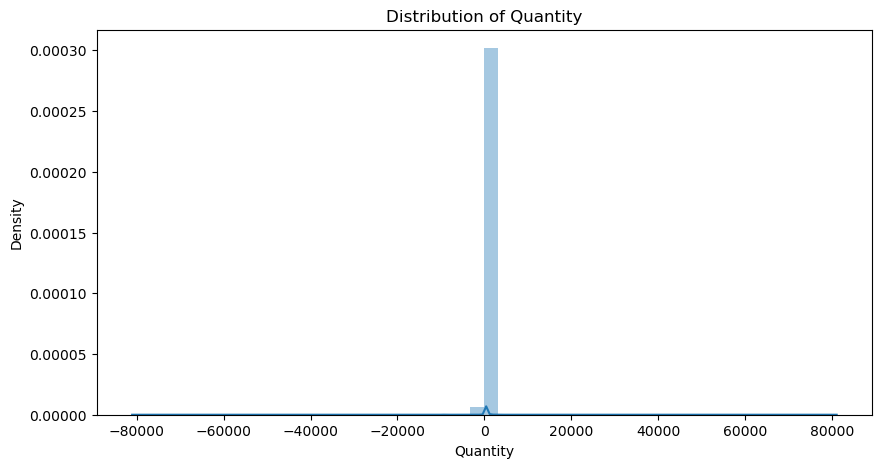

In [8]:
plt.figure(figsize=(10, 5))
sns.distplot(df["Quantity"], kde=True)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity");

Most of our quantities are realteively small (positive) numbers, but there are also some negative quantities as well as extreme outliers (both postiive and negative outliers). 

/tmp/ipykernel_479/2977289605.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["UnitPrice"], kde=True)


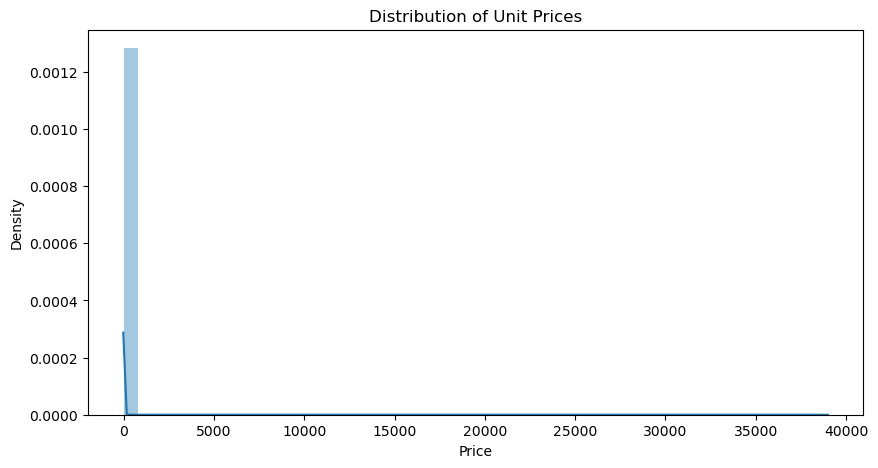

In [9]:
plt.figure(figsize=(10, 5))
sns.distplot(df["UnitPrice"], kde=True)
plt.title("Distribution of Unit Prices")
plt.xlabel("Price");

There are no negative prices, which is good, but we can see some extreme outliers.

In [10]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
df = df.groupby(["StockCode", "Description", "CustomerID", "Country", "UnitPrice"])[
    "Quantity"
].sum()
df = df.loc[df > 0].reset_index()
df.shape

(274399, 6)

In [12]:
def loadDataset(dataframe):
    enc = OneHotEncoder(handle_unknown="ignore")
    onehot_cols = ["StockCode", "CustomerID", "Country"]
    ohe_output = enc.fit_transform(dataframe[onehot_cols])

    vectorizer = TfidfVectorizer(min_df=2)
    unique_descriptions = dataframe["Description"].unique()
    vectorizer.fit(unique_descriptions)
    tfidf_output = vectorizer.transform(dataframe["Description"])

    row = range(len(dataframe))
    col = [0] * len(dataframe)
    unit_price = csr_matrix((dataframe["UnitPrice"].values, (row, col)), dtype="float32")

    X = hstack([ohe_output, tfidf_output, unit_price], format="csr", dtype="float32")

    y = dataframe["Quantity"].values.astype("float32")

    return X, y

In [13]:
X, y = loadDataset(df)

In [14]:
# display sparsity
total_cells = X.shape[0] * X.shape[1]
(total_cells - X.nnz) / total_cells

0.9991284988048746

Our data is over 99.9% sparse. Because of this high sparsity, the sparse matrix data type allows us to represent our data using only a small fraction of the memory that a dense matrix would require.

### Prepare Data For Modeling

+ Split the data into training and testing sets
+ Write the data to protobuf recordIO format for Pipe mode. [Read more](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html) about protobuf recordIO format.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((219519, 9284), (54880, 9284), (219519,), (54880,))

Save numpy arrays to local storage in /data folder


In [16]:
df.to_csv("data/online_retail_preprocessed.csv", index=False)
save_npz("data/X_train.npz", X_train)
save_npz("data/X_test.npz", X_test)
np.savez("data/y_train.npz", y_train)
np.savez("data/y_test.npz", y_test)

In [17]:
prefix = "personalization"

train_key = "train.protobuf"
train_prefix = f"{prefix}/train"

test_key = "test.protobuf"
test_prefix = f"{prefix}/test"

output_prefix = f"s3://{bucket}/{prefix}/output"

In [18]:
def writeDatasetToProtobuf(X, y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, y)
    buf.seek(0)
    obj = "{}/{}".format(prefix, key)
    boto3.resource("s3").Bucket(bucket).Object(obj).upload_fileobj(buf)
    return "s3://{}/{}".format(bucket, obj)


train_data_location = writeDatasetToProtobuf(X_train, y_train, bucket, train_prefix, train_key)
test_data_location = writeDatasetToProtobuf(X_test, y_test, bucket, test_prefix, test_key)

print(train_data_location)
print(test_data_location)
print("Output: {}".format(output_prefix))

s3://sagemaker-us-west-2-688520471316/personalization/train/train.protobuf
s3://sagemaker-us-west-2-688520471316/personalization/test/test.protobuf
Output: s3://sagemaker-us-west-2-688520471316/personalization/output


## Part 2: Train, Tune, and Deploy Model
----
This second part will focus on training, tuning, and deploying a model trained on the data prepared in part 1.

### Solution Architecture
![Architecture](./images/retail_rec_train_reg_deploy.png)

In [19]:
import sagemaker
from sagemaker.lineage import context, artifact, association, action
import boto3

from model_package_src.inference_specification import InferenceSpecification
import json
import numpy as np
import pandas as pd
import datetime
import time
from scipy.sparse import csr_matrix, hstack, load_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [20]:
region = boto3.Session().region_name
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)
sagemaker_role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()

prefix = "personalization"

output_prefix = f"s3://{bucket}/{prefix}/output"

### Prepare Data For Modeling

+ Split the data into training and testing sets
+ Write the data to protobuf recordIO format for Pipe mode. [Read more](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html) about protobuf recordIO format.

In [21]:
# load array
X_train = load_npz("./data/X_train.npz")
X_test = load_npz("./data/X_test.npz")
y_train_npzfile = np.load("./data/y_train.npz")
y_test_npzfile = np.load("./data/y_test.npz")
y_train = y_train_npzfile.f.arr_0
y_test = y_test_npzfile.f.arr_0

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((219519, 9284), (54880, 9284), (219519,), (54880,))

In [22]:
input_dims = X_train.shape[1]

In [23]:
container = sagemaker.image_uris.retrieve("factorization-machines", region=boto_session.region_name)

fm = sagemaker.estimator.Estimator(
    container,
    sagemaker_role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    output_path=output_prefix,
    sagemaker_session=sagemaker_session,
)

fm.set_hyperparameters(
    feature_dim=input_dims,
    predictor_type="regressor",
    mini_batch_size=1000,
    num_factors=64,
    epochs=20,
)

In [24]:
if "training_job_name" not in locals():
    fm.fit({"train": train_data_location, "test": test_data_location})
    training_job_name = fm.latest_training_job.job_name

else:
    print(f"Using previous training job: {training_job_name}")

INFO:sagemaker:Creating training-job with name: factorization-machines-2023-05-19-21-02-51-706


2023-05-19 21:02:51 Starting - Starting the training job...
2023-05-19 21:03:12 Starting - Preparing the instances for training......
2023-05-19 21:04:07 Downloading - Downloading input data...
2023-05-19 21:04:27 Training - Downloading the training image..............Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/19/2023 21:07:04 INFO 140276281280320] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'epochs': 1, 'mini_batch_size': '1000', 'use_bias': 'true', 'use_linear': 'true', 'bias_lr': '0.1', 'linear_lr': '0.001', 'factors_lr': '0.0001', 'bias_wd': '0.01', 'linear_wd': '0.001', 'factors_wd': '0.00001', 'bias_init_method': 'normal', 'bias_init_sigma': '0.01', 'linear_init_method': 'normal', 'linear_init_sigma': '0.01', 'factors_init_method': 'normal', 'factors_init_sigma': '0.001', 'batch_metrics_publish_interval': '500', '_data_format': 'record', '_kvstore': 'a

## Make Predictions

Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint. This will allow out to make predictions (or inference) from the model dyanamically.

Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target.

Here we will take the top customer, the customer who spent the most money, and try to find which items to recommend to them.

In [25]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer

In [26]:
class FMSerializer(JSONSerializer):
    def serialize(self, data):
        js = {"instances": []}
        for row in data:
            js["instances"].append({"features": row.tolist()})
        return json.dumps(js)


fm_predictor = fm.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=FMSerializer(),
    deserializer=JSONDeserializer(),
)

INFO:sagemaker:Creating model with name: factorization-machines-2023-05-19-21-08-07-037
INFO:sagemaker:Creating endpoint-config with name factorization-machines-2023-05-19-21-08-07-037
INFO:sagemaker:Creating endpoint with name factorization-machines-2023-05-19-21-08-07-037


---------!

In [27]:
# find customer who spent the most money
df = pd.read_csv("data/online_retail_preprocessed.csv")

df["invoice_amount"] = df["Quantity"] * df["UnitPrice"]
top_customer = (
    df.groupby("CustomerID").sum()["invoice_amount"].sort_values(ascending=False).index[0]
)

In [28]:
def get_recommendations(df, customer_id, n_recommendations, n_ranks=100):
    popular_items = (
        df.groupby(["StockCode", "UnitPrice"])
        .nunique()["CustomerID"]
        .sort_values(ascending=False)
        .reset_index()
    )
    top_n_items = popular_items["StockCode"].iloc[:n_ranks].values
    top_n_prices = popular_items["UnitPrice"].iloc[:n_ranks].values

    # stock codes can have multiple descriptions, so we will choose whichever description is most common
    item_map = df.groupby("StockCode").agg(lambda x: x.value_counts().index[0])["Description"]

    # find customer's country
    df_subset = df.loc[df["CustomerID"] == customer_id]
    country = df_subset["Country"].value_counts().index[0]

    data = []
    flattened_item_map = [item_map[i] for i in top_n_items]
    for idx in range(len(top_n_items)):
        data.append(
            {
                "StockCode": top_n_items[idx],
                "Description": flattened_item_map[idx],
                "CustomerID": customer_id,
                "Country": country,
                "UnitPrice": top_n_prices[idx],
            }
        )

    df_inference = pd.DataFrame(data)

    # we need to build the data set similar to how we built it for training
    # it should have the same number of features as the training data
    enc = OneHotEncoder(handle_unknown="ignore")
    onehot_cols = ["StockCode", "CustomerID", "Country"]
    enc.fit(df[onehot_cols])
    onehot_output = enc.transform(df_inference[onehot_cols])

    vectorizer = TfidfVectorizer(min_df=2)
    unique_descriptions = df["Description"].unique()
    vectorizer.fit(unique_descriptions)
    tfidf_output = vectorizer.transform(df_inference["Description"])

    row = range(len(df_inference))
    col = [0] * len(df_inference)
    unit_price = csr_matrix((df_inference["UnitPrice"].values, (row, col)), dtype="float32")

    X_inference = hstack([onehot_output, tfidf_output, unit_price], format="csr")

    result = fm_predictor.predict(X_inference.toarray())
    preds = [i["score"] for i in result["predictions"]]
    index_array = np.array(preds).argsort()
    items = enc.inverse_transform(onehot_output)[:, 0]
    top_recs = np.take_along_axis(items, index_array, axis=0)[: -n_recommendations - 1 : -1]
    recommendations = [[i, item_map[i]] for i in top_recs]
    return recommendations

In [29]:
print("Top 5 recommended products:")
get_recommendations(df, top_customer, n_recommendations=5, n_ranks=100)

Top 5 recommended products:


[['22423', 'REGENCY CAKESTAND 3 TIER'],
 ['22776', 'SWEETHEART CAKESTAND 3 TIER'],
 ['22624', 'IVORY KITCHEN SCALES'],
 ['85123A', 'WHITE HANGING HEART T-LIGHT HOLDER'],
 ['85099B', 'JUMBO BAG RED RETROSPOT']]

Once you are done with the endpoint, you should delete the endpoint to save cost and free resources.

In [30]:
fm_predictor.delete_model()
fm_predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: factorization-machines-2023-05-19-21-08-07-037
INFO:sagemaker:Deleting endpoint configuration with name: factorization-machines-2023-05-19-21-08-07-037
INFO:sagemaker:Deleting endpoint with name: factorization-machines-2023-05-19-21-08-07-037


## Optional Part: Registering the Model in SageMaker Model Registry

Once a useful model has been trained, you have the option to register the model for future reference and possible deployment. To do so, we must first properly associate the artifacts of the model.

### Training data artifact

In [31]:
training_job_info = sagemaker_boto_client.describe_training_job(TrainingJobName=training_job_name)

In [32]:
training_data_s3_uri = training_job_info["InputDataConfig"][0]["DataSource"]["S3DataSource"][
    "S3Uri"
]

matching_artifacts = list(
    artifact.Artifact.list(source_uri=training_data_s3_uri, sagemaker_session=sagemaker_session)
)

if matching_artifacts:
    training_data_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {training_data_artifact.artifact_arn}")
else:
    training_data_artifact = artifact.Artifact.create(
        artifact_name="TrainingData",
        source_uri=training_data_s3_uri,
        artifact_type="Dataset",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {training_data_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-west-2:688520471316:artifact/8e1ace0bbe329cf696791077318c488a


### Code Artifact

We do not need a code artifact because we are using a built-in SageMaker Algorithm called Factorization Machines. The Factorization Machines container contains all of the code and, by default, our model training stores the Factorization Machines image for tracking purposes.

### Model artifact

In [33]:
trained_model_s3_uri = training_job_info["ModelArtifacts"]["S3ModelArtifacts"]

matching_artifacts = list(
    artifact.Artifact.list(source_uri=trained_model_s3_uri, sagemaker_session=sagemaker_session)
)

if matching_artifacts:
    model_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {model_artifact.artifact_arn}")
else:
    model_artifact = artifact.Artifact.create(
        artifact_name="TrainedModel",
        source_uri=trained_model_s3_uri,
        artifact_type="Model",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {model_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-west-2:688520471316:artifact/4d5ce055a79a1fc6ec1cd72199eb346f


#### Set artifact associations

In [34]:
trial_component = sagemaker_boto_client.describe_trial_component(
    TrialComponentName=training_job_name + "-aws-training-job"
)
trial_component_arn = trial_component["TrialComponentArn"]

#### Store artifacts

In [35]:
artifact_list = [[training_data_artifact, "ContributedTo"], [model_artifact, "Produced"]]

for art, assoc in artifact_list:
    try:
        association.Association.create(
            source_arn=art.artifact_arn,
            destination_arn=trial_component_arn,
            association_type=assoc,
            sagemaker_session=sagemaker_session,
        )
        print(f"Association with {art.artifact_type}: SUCCEESFUL")
    except:
        print(f"Association already exists with {art.artifact_type}")

Association already exists with DataSet
Association with Model: SUCCEESFUL


In [36]:
model_name = "retail-recommendations"
model_matches = sagemaker_boto_client.list_models(NameContains=model_name)["Models"]

if not model_matches:
    print(f"Creating model {model_name}")
    model = sagemaker_session.create_model_from_job(
        name=model_name,
        training_job_name=training_job_info["TrainingJobName"],
        role=sagemaker_role,
        image_uri=training_job_info["AlgorithmSpecification"]["TrainingImage"],
    )
else:
    print(f"Model {model_name} already exists.")

INFO:sagemaker:Creating model with name: retail-recommendations


Creating model retail-recommendations


### Create Model Package Group

After associating all the relevant artifacts, the Model Package Group can now be created. A Model Package Groups holds multiple versions or iterations of a model. Though it is not required to create them for every model in the registry, they help organize various models which all have the same purpose and provide autiomatic versioning.

In [37]:
if "mpg_name" not in locals():
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
    mpg_name = f"retail-recommendation-{timestamp}"

print(f"Model Package Group name: {mpg_name}")

Model Package Group name: retail-recommendation-2023-05-19-21-13


In [38]:
mpg_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageGroupDescription": "Recommendation for Online Retail Sales",
}

In [39]:
matching_mpg = sagemaker_boto_client.list_model_package_groups(NameContains=mpg_name)[
    "ModelPackageGroupSummaryList"
]

if matching_mpg:
    print(f"Using existing Model Package Group: {mpg_name}")
else:
    mpg_response = sagemaker_boto_client.create_model_package_group(**mpg_input_dict)
    print(f"Create Model Package Group {mpg_name}: SUCCESSFUL")

Create Model Package Group retail-recommendation-2023-05-19-21-13: SUCCESSFUL


In [40]:
model_metrics_report = {"regression_metrics": {}}

for metric in training_job_info["FinalMetricDataList"]:
    stat = {metric["MetricName"]: {"value": metric["Value"]}}
    model_metrics_report["regression_metrics"].update(stat)

with open("training_metrics.json", "w") as f:
    json.dump(model_metrics_report, f)

metrics_s3_key = f"training_jobs/{training_job_info['TrainingJobName']}/training_metrics.json"
s3_client.upload_file(Filename="training_metrics.json", Bucket=bucket, Key=metrics_s3_key)

#### Define the inference spec

In [41]:
mp_inference_spec = InferenceSpecification().get_inference_specification_dict(
    ecr_image=training_job_info["AlgorithmSpecification"]["TrainingImage"],
    supports_gpu=False,
    supported_content_types=["application/x-recordio-protobuf", "application/json"],
    supported_mime_types=["text/csv"],
)

mp_inference_spec["InferenceSpecification"]["Containers"][0]["ModelDataUrl"] = training_job_info[
    "ModelArtifacts"
]["S3ModelArtifacts"]

#### Define model metrics

Metrics other than model quality can be defined. See the Boto3 documentation for [creating a model package](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_model_package).

In [42]:
model_metrics = {
    "ModelQuality": {
        "Statistics": {
            "ContentType": "application/json",
            "S3Uri": f"s3://{bucket}/{metrics_s3_key}",
        }
    }
}

In [43]:
mp_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageDescription": "Factorization Machine Model to create personalized retail recommendations",
    "ModelApprovalStatus": "PendingManualApproval",
    "ModelMetrics": model_metrics,
}

mp_input_dict.update(mp_inference_spec)
mp_response = sagemaker_boto_client.create_model_package(**mp_input_dict)

### Wait until model package is completed

In [44]:
mp_info = sagemaker_boto_client.describe_model_package(
    ModelPackageName=mp_response["ModelPackageArn"]
)
mp_status = mp_info["ModelPackageStatus"]

while mp_status not in ["Completed", "Failed"]:
    time.sleep(5)
    mp_info = sagemaker_boto_client.describe_model_package(
        ModelPackageName=mp_response["ModelPackageArn"]
    )
    mp_status = mp_info["ModelPackageStatus"]
    print(f"model package status: {mp_status}")
print(f"model package status: {mp_status}")

model package status: Completed


In [45]:
model_package = sagemaker_boto_client.list_model_packages(ModelPackageGroupName=mpg_name)[
    "ModelPackageSummaryList"
][0]
model_package_update = {
    "ModelPackageArn": model_package["ModelPackageArn"],
    "ModelApprovalStatus": "Approved",
}

update_response = sagemaker_boto_client.update_model_package(**model_package_update)

In [46]:
from sagemaker.lineage.visualizer import LineageTableVisualizer

viz = LineageTableVisualizer(sagemaker_session)
display(viz.show(training_job_name=training_job_name))

,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...3-05-19-21-02-51-706/output/model.tar.gz,Input,Model,Produced,artifact
1,s3://...71316/personalization/test/test.protobuf,Input,DataSet,ContributedTo,artifact
2,s3://...316/personalization/train/train.protobuf,Input,DataSet,ContributedTo,artifact
3,17487...2.amazonaws.com/factorization-machines:1,Input,Image,ContributedTo,artifact
4,s3://...3-05-19-21-02-51-706/output/model.tar.gz,Output,Model,Produced,artifact


## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/use-cases|retail_recommend|retail_recommend.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/use-cases|retail_recommend|retail_recommend.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/use-cases|retail_recommend|retail_recommend.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/use-cases|retail_recommend|retail_recommend.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/use-cases|retail_recommend|retail_recommend.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/use-cases|retail_recommend|retail_recommend.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/use-cases|retail_recommend|retail_recommend.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/use-cases|retail_recommend|retail_recommend.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/use-cases|retail_recommend|retail_recommend.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/use-cases|retail_recommend|retail_recommend.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/use-cases|retail_recommend|retail_recommend.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/use-cases|retail_recommend|retail_recommend.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/use-cases|retail_recommend|retail_recommend.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/use-cases|retail_recommend|retail_recommend.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/use-cases|retail_recommend|retail_recommend.ipynb)
